<a href="https://colab.research.google.com/github/twelvesense/first-repository/blob/master/GoCvNode02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **프로젝트: CutMix 또는 Mixup 비교실험 하기**

# 1: 사전준비

## 1.1: 라이브러리

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

## 1.2: 데이터셋

In [2]:
# stanford_dogs
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteKPRPUF/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteKPRPUF/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [34]:
ds_info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    version=0.2.0,
    description='The Stanford Dogs dataset contains images of 120 breeds of dogs from around
the world. This dataset has been built using images and annotation from
ImageNet for the task of fine-grained image categorization. There are
20,580 images, out of which 12,000 are used for training and 8580 for
testing. Class labels and bounding box annotations are provided
for all the 12,000 images.',
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        }),
    }),
    total_num_examples=20580,
    splits={
        'test': 8580,
        'train': 12000,
    },
    supervised_keys=('image'

In [35]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

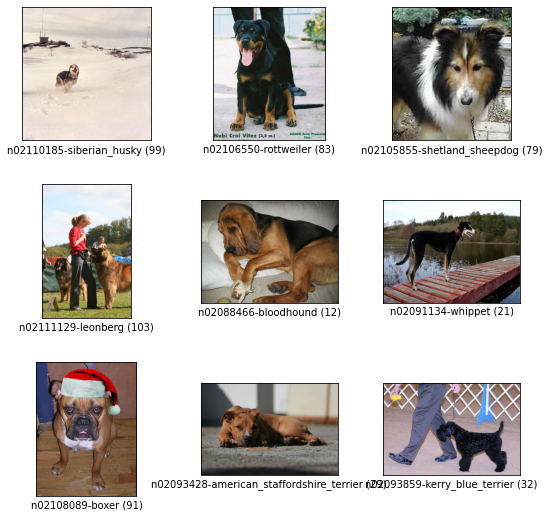

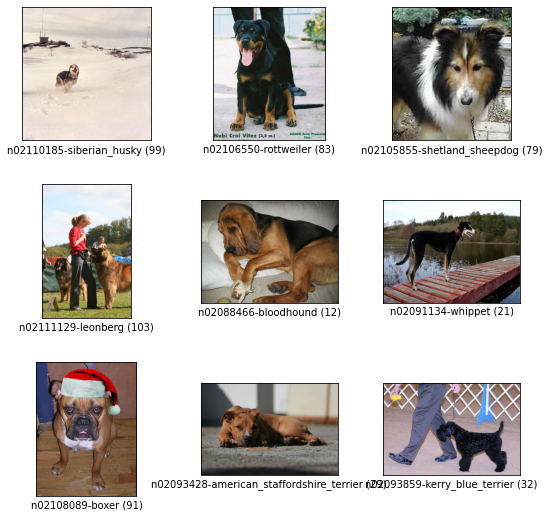

In [36]:
tfds.show_examples(ds_train, ds_info)

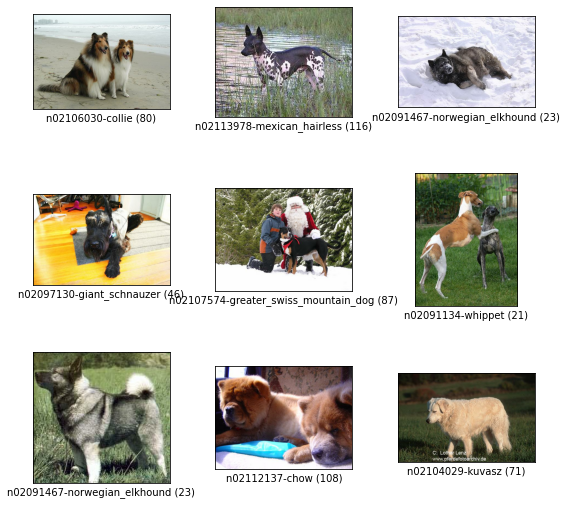

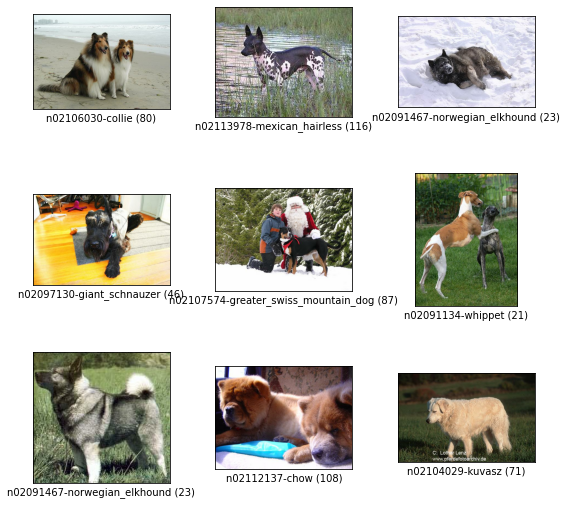

In [37]:
tfds.show_examples(ds_test, ds_info)

## 1.3: 함수

In [38]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

# image_a에서 바운딩 박스 바깥쪽 영역을, image_b에서 바운딩 박스 안쪽 영역을 합치는 함수
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = 224
    image_size_y = 224
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

# CutMix 공식 repo 처럼, width, height가 다르더라도 가변적으로 적용할 수 있도록 구현
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

# mix_2_images()와 mix_2_label()을 활용하여 배치 단위의 cutmix() 구현
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels    

# 일반적인 전처리 과정: normalize, resize, augmentation, shuffle
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(normalize_and_resize_img,num_parallel_calls=2)
    if not is_test and with_aug:
        ds = ds.map(augment)
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(cutmix, num_parallel_calls=2)
    elif not is_test and with_mixup:
        ds = ds.map(mixup, num_parallel_calls=2)
    else:
        ds = ds.map(onehot, num_parallel_calls=2)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# 2: Augmentation을 적용한 데이터셋 만들기

In [39]:
# apply_normalize_on_dataset()에서 with_aug, with_cutmix, with_mixup 적용
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [49]:
ds_train_with_cutmix = ds_train_aug.concatenate(ds_train_cutmix)

In [50]:
ds_train_with_mixup = ds_train_aug.concatenate(ds_train_mixup)

# 3: 모델 만들기

In [42]:
# ResNet50 중 imagenet으로 훈련된 모델
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Augmentation을 적용한 데이터셋으로 학습시킬 ResNet
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# cutmix augmentation을 적용한 데이터셋으로 학습시킬 ResNet
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# mixup augmentation을 적용한 데이터셋으로 학습시킬 ResNet
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 1s 0us/step


# 4: 모델 훈련하기

In [43]:
EPOCH = 20

In [44]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [45]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [46]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [47]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [48]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 105s 117ms/step - loss: 2.2282 - accuracy: 0.4422 - val_loss: 3.6674 - val_accuracy: 0.1644
Epoch 2/20
750/750 [==============================] - 86s 115ms/step - loss: 0.7182 - accuracy: 0.7995 - val_loss: 1.1607 - val_accuracy: 0.6686
Epoch 3/20
750/750 [==============================] - 86s 115ms/step - loss: 0.2254 - accuracy: 0.9528 - val_loss: 0.9726 - val_accuracy: 0.7196
Epoch 4/20
750/750 [==============================] - 86s 115ms/step - loss: 0.0543 - accuracy: 0.9955 - val_loss: 0.9036 - val_accuracy: 0.7442
Epoch 5/20
750/750 [==============================] - 87s 115ms/step - loss: 0.0202 - accuracy: 0.9998 - val_loss: 0.9084 - val_accuracy: 0.7464
Epoch 6/20
750/750 [==============================] - 92s 122ms/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 0.9215 - val_accuracy: 0.7474
Epoch 7/20
750/750 [==============================] - 86s 115ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.9297 - val_a

In [51]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 93s 116ms/step - loss: 2.2865 - accuracy: 0.4299 - val_loss: 3.2345 - val_accuracy: 0.2311
Epoch 2/20
750/750 [==============================] - 86s 115ms/step - loss: 0.9300 - accuracy: 0.7349 - val_loss: 1.3285 - val_accuracy: 0.6179
Epoch 3/20
750/750 [==============================] - 87s 115ms/step - loss: 0.4789 - accuracy: 0.8701 - val_loss: 1.0441 - val_accuracy: 0.6936
Epoch 4/20
750/750 [==============================] - 92s 122ms/step - loss: 0.2462 - accuracy: 0.9425 - val_loss: 1.1281 - val_accuracy: 0.6840
Epoch 5/20
750/750 [==============================] - 87s 116ms/step - loss: 0.1302 - accuracy: 0.9765 - val_loss: 0.9375 - val_accuracy: 0.7290
Epoch 6/20
750/750 [==============================] - 88s 117ms/step - loss: 0.0716 - accuracy: 0.9900 - val_loss: 1.0043 - val_accuracy: 0.7226
Epoch 7/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0406 - accuracy: 0.9962 - val_loss: 0.9861 - val_ac

In [53]:
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_with_cutmix, # cutmix augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 95s 117ms/step - loss: 2.2551 - accuracy: 0.4341 - val_loss: 3.4268 - val_accuracy: 0.1894
Epoch 2/20
750/750 [==============================] - 88s 117ms/step - loss: 0.9277 - accuracy: 0.7401 - val_loss: 1.2581 - val_accuracy: 0.6368
Epoch 3/20
750/750 [==============================] - 88s 117ms/step - loss: 0.4835 - accuracy: 0.8678 - val_loss: 1.1929 - val_accuracy: 0.6572
Epoch 4/20
750/750 [==============================] - 88s 117ms/step - loss: 0.2427 - accuracy: 0.9439 - val_loss: 1.0228 - val_accuracy: 0.7069
Epoch 5/20
750/750 [==============================] - 87s 117ms/step - loss: 0.1315 - accuracy: 0.9756 - val_loss: 1.0444 - val_accuracy: 0.7062
Epoch 6/20
750/750 [==============================] - 88s 117ms/step - loss: 0.0759 - accuracy: 0.9889 - val_loss: 0.9768 - val_accuracy: 0.7309
Epoch 7/20
750/750 [==============================] - 88s 117ms/step - loss: 0.0447 - accuracy: 0.9946 - val_loss: 0.9598 - val_ac

In [54]:
history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_with_mixup, # mixup augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 99s 124ms/step - loss: 2.2642 - accuracy: 0.4310 - val_loss: 2.8659 - val_accuracy: 0.2922
Epoch 2/20
750/750 [==============================] - 88s 117ms/step - loss: 0.9416 - accuracy: 0.7330 - val_loss: 1.3940 - val_accuracy: 0.6042
Epoch 3/20
750/750 [==============================] - 88s 117ms/step - loss: 0.4668 - accuracy: 0.8728 - val_loss: 1.1210 - val_accuracy: 0.6797
Epoch 4/20
750/750 [==============================] - 88s 117ms/step - loss: 0.2528 - accuracy: 0.9414 - val_loss: 1.1431 - val_accuracy: 0.6715
Epoch 5/20
750/750 [==============================] - 87s 117ms/step - loss: 0.2068 - accuracy: 0.9533 - val_loss: 1.0763 - val_accuracy: 0.6899
Epoch 6/20
750/750 [==============================] - 88s 117ms/step - loss: 0.0885 - accuracy: 0.9861 - val_loss: 0.9279 - val_accuracy: 0.7382
Epoch 7/20
750/750 [==============================] - 93s 123ms/step - loss: 0.0458 - accuracy: 0.9945 - val_loss: 0.9716 - val_ac

# 5: 훈련 과정 시각화하기
훈련 과정의 히스토리를 그래프로 시각화해 주세요.

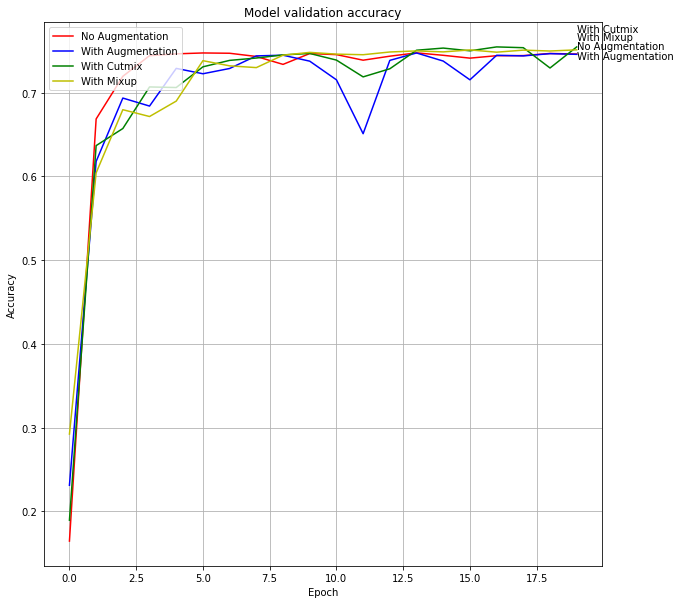

In [60]:
# 훈련 과정을 시각화 해봅시다.
plt.figure(figsize=(10, 10))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')
plt.annotate('No Augmentation', (19, history_resnet50_no_aug.history['val_accuracy'][19]), textcoords="offset points", xytext=(0,5), ha='left')
plt.annotate('With Augmentation', (19, history_resnet50_aug.history['val_accuracy'][19]), textcoords="offset points", xytext=(0,-5), ha='left')
plt.annotate('With Cutmix', (19, history_resnet50_cutmix.history['val_accuracy'][19]), textcoords="offset points", xytext=(0,15), ha='left')
plt.annotate('With Mixup', (19, history_resnet50_mixup.history['val_accuracy'][19]), textcoords="offset points", xytext=(0,10), ha='left')
plt.grid(True)
# plt.show()

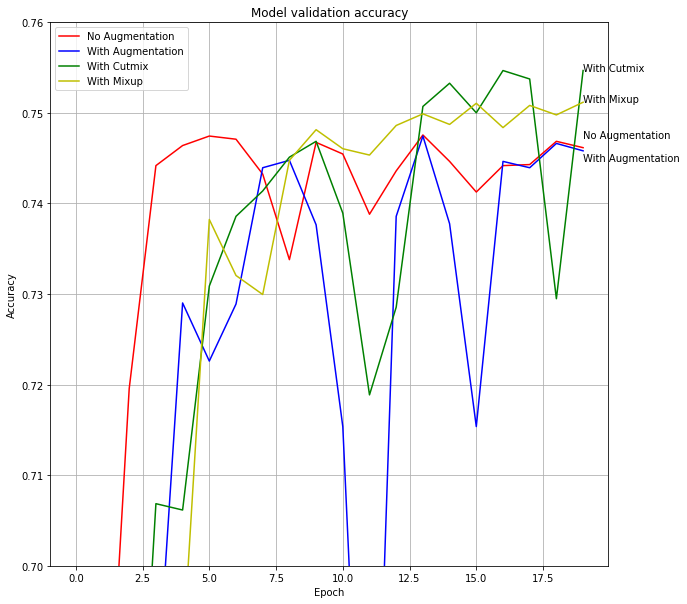

In [58]:
# 조금 더 확대해 살펴봅시다.
plt.figure(figsize=(10, 10))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')
plt.annotate('No Augmentation', (19, history_resnet50_no_aug.history['val_accuracy'][19]), textcoords="offset points", xytext=(0,10), ha='left')
plt.annotate('With Augmentation', (19, history_resnet50_aug.history['val_accuracy'][19]), textcoords="offset points", xytext=(0,-10), ha='left')
plt.annotate('With Cutmix', (19, history_resnet50_cutmix.history['val_accuracy'][19]), textcoords="offset points", xytext=(0,0), ha='left')
plt.annotate('With Mixup', (19, history_resnet50_mixup.history['val_accuracy'][19]), textcoords="offset points", xytext=(0,0), ha='left')
plt.ylim(0.70, 0.76)
plt.grid(True)
plt.show()

In [61]:
max(history_resnet50_no_aug.history['val_accuracy'])

0.7475513219833374

In [62]:
max(history_resnet50_aug.history['val_accuracy'])

0.747434675693512

In [63]:
max(history_resnet50_cutmix.history['val_accuracy'])

0.7546641826629639

In [64]:
max(history_resnet50_mixup.history['val_accuracy'])

0.751166045665741

In [65]:
history_resnet50_no_aug.history['val_accuracy'][19]

0.7461520433425903

In [66]:
history_resnet50_aug.history['val_accuracy'][19]

0.7458022236824036

In [67]:
history_resnet50_cutmix.history['val_accuracy'][19]

0.7546641826629639

In [68]:
history_resnet50_mixup.history['val_accuracy'][19]

0.751166045665741

# 6: Augmentation에 의한 모델 성능 비교

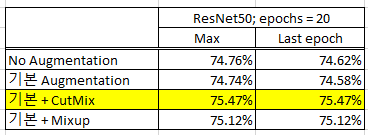

* 20 epoch중 최대(Max)값 및 마지막 20번째 epoch 기준으로 Validation accuracy를 평가했다.
* 기본+CutMix augmentation이 가장 좋은 성능을 보였고, 다음은 기본+Mixup 이었다.
* 초반 epoch에서는 no augmentation의 성능이 좋지만, 10 epoch 이후로 상황이 바뀌었다.

#7: 회고

* Augmentation  적용한  경우가 초반 학습은 늦어도, EPOCH 10
 전후해서 더 좋아지는 걸 확인했다. 
* Cutmix, Mixup Augmentation이 효과가 있음을 확인할 수 있었다.